In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [2]:
annotation_file = 'annotations/captions_train2014.json'
image_folder ='train2014'


In [3]:
with open(annotation_file, 'r')as f:
    annotations = json.load(f)

In [4]:
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path ='train2014/COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:15000]
print(len(train_image_paths)) 

15000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> An office desk with two laptops and a desktop computer. <end>


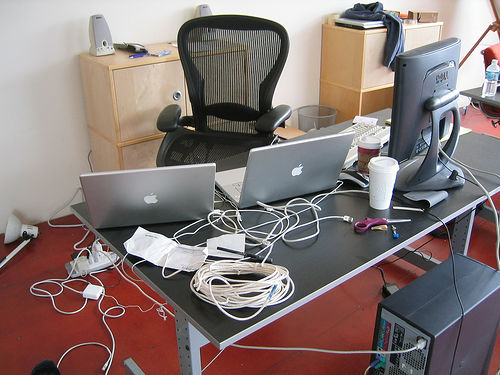

In [7]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [17]:
from keras.applications.inception_v3 import preprocess_input

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img,channels =3)
    img = tf.image.resize(img, (299,299))
    img = preprocess_input(img)

    return img, img_path


In [18]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [19]:
from tqdm import tqdm 

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

235it [03:30,  1.12it/s]


In [20]:
def calc_max_lenght(tensor):
    return max(len(t) for t in tensor)

top_k = 7000
tokenizer =tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token= '<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)


In [21]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [22]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [24]:
max_len = calc_max_lenght(train_seqs)


In [25]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(60031, 60031, 15005, 15005)

In [27]:
BATCH_SIZE = 64
BUFFER_SIZE = 1200
embedding_dim = 256
units = 1024
vocab_size = top_k + 1
num_steps = len(img_name_train) 

features_shape =2048
attention_feature_shape = 64

In [28]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)